# Predicting Freemium to Premium Adoption

Website XYZ is a music-listening social platform using a freemium model, offering basic services for free and premium features via subscription. The goal is to identify which current non-premium users are most likely to adopt a premium subscription if targeted by a marketing campaign.

This notebook builds a robust prediction pipeline using:
- Data preprocessing and feature understanding
- Class imbalance handling
- Nested cross-validation for model selection
- Hyperparameter tuning of XGBoost
- Threshold tuning for recall optimization
- Model interpretation using SHAP
- ROI and campaign insights using an LLM-driven Streamlit dashboard


# 1. Setup and Library Imports

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Core
import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
)
# Imbalance
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP
import shap

# Save final model
import joblib

# 2. Load and Explore the Data

### Dataset Overview

The dataset includes user-level behavioral and demographic information such as:

- Number of songs listened
- Loved tracks
- Age
- Posts, shouts
- Subscriber friends
- Gender

The target variable is:
- `adopter`: Whether the user adopted the premium service.

We aim to use these features to classify whether a free user is likely to adopt in the next 6 months.


In [20]:
df = pd.read_csv("XYZData.csv")
print(df.shape)
df.head()

(41540, 27)


,user_id,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,...,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,adopter
0,10,24,0,20,26.333333,0.777778,6,0,37804,4,...,0,54,0,0,0,0,79,0,0,0
1,137,22,1,4,21.250000,0.750000,1,0,774,0,...,0,0,0,0,0,0,60,0,0,0
2,306,18,0,3,18.500000,0.666667,1,0,14036,1,...,0,0,0,0,0,0,41,1,0,0
3,336,24,1,131,23.907407,0.431034,22,4,3457,227,...,2,865,7,0,0,4,79,0,0,0
4,355,23,1,15,21.555556,0.461538,2,1,7506,0,...,0,-4,0,0,0,6,70,0,0,0


In [24]:
df.isna().sum()

user_id                        0
age                            0
male                           0
friend_cnt                     0
avg_friend_age                 0
avg_friend_male                0
friend_country_cnt             0
subscriber_friend_cnt          0
songsListened                  0
lovedTracks                    0
posts                          0
playlists                      0
shouts                         0
delta_friend_cnt               0
delta_avg_friend_age           0
delta_avg_friend_male          0
delta_friend_country_cnt       0
delta_subscriber_friend_cnt    0
delta_songsListened            0
delta_lovedTracks              0
delta_posts                    0
delta_playlists                0
delta_shouts                   0
tenure                         0
good_country                   0
delta_good_country             0
adopter                        0
dtype: int64

In [26]:
df.describe()

,user_id,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,...,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,adopter
count,4.154000e+04,41540.000000,41540.000000,41540.000000,41540.000000,41540.000000,41540.000000,41540.000000,41540.000000,41540.00000,...,41540.000000,41540.000000,41540.000000,41540.000000,41540.000000,41540.000000,41540.000000,41540.000000,41540.000000,41540.000000
mean,8.532359e+05,24.005031,0.624482,19.436495,24.070715,0.618523,4.087891,0.459557,18598.273375,92.51856,...,-0.022653,970.865359,4.569475,0.107679,0.003009,0.995450,44.379803,0.352744,0.000361,0.037073
std,4.937634e+05,6.395873,0.484262,64.604406,5.123732,0.316903,5.929288,2.086210,29152.079493,267.06124,...,0.560238,3160.513338,35.021772,4.632349,0.149517,16.193033,19.708478,0.477830,0.035038,0.188942
min,1.000000e+01,8.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,-18.000000,-135022.000000,-951.000000,-1.000000,-3.000000,-451.000000,1.000000,0.000000,-1.000000,0.000000
25%,4.243720e+05,20.000000,0.000000,3.000000,20.750000,0.428571,1.000000,0.000000,1444.000000,1.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000
50%,8.502295e+05,23.000000,1.000000,7.000000,23.000000,0.666667,2.000000,0.000000,8102.000000,16.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000
75%,1.281096e+06,26.000000,1.000000,19.000000,26.200000,0.900000,4.000000,0.000000,24164.000000,78.00000,...,0.000000,950.500000,0.000000,0.000000,0.000000,0.000000,59.000000,1.000000,0.000000,0.000000
max,1.708935e+06,78.000000,1.000000,6437.000000,77.000000,1.000000,119.000000,225.000000,922370.000000,10252.00000,...,19.000000,217876.000000,2319.000000,557.000000,9.000000,2036.000000,108.000000,1.000000,1.000000,1.000000


### The target variable **adoption is highly imbalanced**, with <30% of users adopting. This can be handled using **SMOTE** later in modeling.

In [7]:
# Check target balance
print(df['adopter'].value_counts(normalize=True))

adopter
0    0.962927
1    0.037073
Name: proportion, dtype: float64


# 3. Preprocessing Setup

Steps taken before modeling:

- Removed identifiers (`user_id`) and columns with leakage.
- Standardized features using `StandardScaler`.
- Applied **SMOTE** for balancing the training set.
- Split into `train_val` and `holdout` sets using stratification.

All transformations were included within **pipelines** to avoid data leakage.

In [12]:
user_ids = df['user_id']
X = df.drop(columns = ["adopter","user_id"])
y = df["adopter"]

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)])

In [14]:
numeric_features

['age',
 'male',
 'friend_cnt',
 'avg_friend_age',
 'avg_friend_male',
 'friend_country_cnt',
 'subscriber_friend_cnt',
 'songsListened',
 'lovedTracks',
 'posts',
 'playlists',
 'shouts',
 'delta_friend_cnt',
 'delta_avg_friend_age',
 'delta_avg_friend_male',
 'delta_friend_country_cnt',
 'delta_subscriber_friend_cnt',
 'delta_songsListened',
 'delta_lovedTracks',
 'delta_posts',
 'delta_playlists',
 'delta_shouts',
 'tenure',
 'good_country',
 'delta_good_country']

# 4. Train-Test-Validation Split

In [17]:
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 5. Nested Cross-Validation for Model Selection (Recall-Focused)

We used **Nested Cross-Validation** for model selection:

- Outer Loop (5-fold): Model performance estimation
- Inner Loop (3-fold): Hyperparameter tuning

Models evaluated:

- Logistic Regression
- Random Forest
- XGBoost (Best)
- LightGBM
- Neural Network (MLP)

Prioritized **Recall** to focus on correctly identifying adopters.


### Model Comparison Summary

Before finalizing the XGBoost model, several classification algorithms were evaluated based on key performance metrics: **Accuracy**, **Precision**, **Recall**, **F1-Score**, and **ROC AUC**.

| Model               | Accuracy | Precision | Recall | F1-Score | ROC AUC |
|--------------------|----------|-----------|--------|----------|---------|
| **XGBoost**         | 0.037855 | 0.037102  | **1.000000** | 0.071549 | 0.758126 |
| Logistic Regression | 0.068608 | 0.038005  | 0.991886 | 0.073205 | 0.701815 |
| LightGBM            | 0.545588 | 0.066606  | 0.865291 | 0.123683 | 0.767447 |
| Random Forest       | **0.688974** | **0.081364**  | 0.718386 | **0.146148** | **0.777019** |

### Key Observations:

- **XGBoost** achieved **perfect recall (1.0)**, capturing all adopters, which is desirable in cases where **missing a positive case (adopter)** is more costly than a false alarm.
- However, **XGBoost has low precision (0.037)**, indicating a high number of false positives. This trade-off is common in recall-optimized models.
- **Random Forest** provides a more balanced performance across all metrics and had the **highest F1-score** and **ROC AUC**, making it a strong contender for real-world deployment.
- **Logistic Regression**, while interpretable, performed poorly on most metrics compared to the ensemble models.
- **LightGBM** offered a reasonable middle ground, with decent recall and ROC AUC.

### Conclusion:

While XGBoost was optimized for **maximum recall**—critical in scenarios where catching all potential adopters is prioritized—it may not be the best standalone model unless paired with post-filtering logic or cost-sensitive strategies. **Random Forest** or **LightGBM** may be considered for more balanced performance, especially when false positives need to be controlled.



In [73]:
# Define models and params
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(verbose=-1, is_unbalance=True),
}

param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        "clf__n_estimators": [100],
        "clf__max_depth": [None, 10]
    },
    "XGBoost": {
        "clf__learning_rate": [0.1, 0.01],
        "clf__max_depth": [3, 5],
        "clf__scale_pos_weight": [10, 15]
    },
    "LightGBM": {
        "clf__learning_rate": [0.1, 0.01],
        "clf__num_leaves": [31, 50],
    }
}


In [75]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring_metrics = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score, needs_proba=True)
}

results = {}

for model_name, model in models.items():
    print(f"\n Training {model_name}...")
    scores = {metric: [] for metric in scoring_metrics}
    
    for train_idx, test_idx in outer_cv.split(X_train_main, y_train_main):
        X_train, X_test = X_train_main.iloc[train_idx], X_train_main.iloc[test_idx]
        y_train, y_test = y_train_main.iloc[train_idx], y_train_main.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        pipeline = Pipeline([
                ("smote", SMOTE(random_state=1)),
                ("clf", model)
            ])

        grid_search = GridSearchCV(
            pipeline,
            param_grid=param_grids[model_name],
            cv=inner_cv,
            scoring="recall",
            refit=True,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        y_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba > 0.3).astype(int)

        for metric in scoring_metrics:
            if metric == "roc_auc":
                if y_proba is not None:
                    scores[metric].append(roc_auc_score(y_test, y_proba))
            else:
                scores[metric].append(scoring_metrics[metric]._score_func(y_test, y_pred))

    avg_scores = {metric: np.mean(vals) for metric, vals in scores.items()}
    results[model_name] = avg_scores

results_df = pd.DataFrame(results).T.sort_values(by="recall", ascending=False)
results_df


 Training Logistic Regression...

 Training Random Forest...

 Training XGBoost...

 Training LightGBM...


,accuracy,precision,recall,f1,roc_auc
XGBoost,0.037855,0.037102,1.000000,0.071549,0.758126
Logistic Regression,0.068608,0.038005,0.991886,0.073205,0.701815
LightGBM,0.545588,0.066606,0.865291,0.123683,0.767447
Random Forest,0.688974,0.081364,0.718386,0.146148,0.777019


# 6. Final XGBoost Model Performance Summary

After identifying **XGBoost** as the top performer via Nested CV:

- Re-tuned it using an **expanded hyperparameter grid**.
- Re-trained the model on the full training set.
- Used `scale_pos_weight` for imbalance handling.
- Evaluated on holdout set using:
  - Accuracy, Recall, Precision, F1
  - AUC
  - Confusion Matrix

After nested cross-validation and extensive hyperparameter tuning, the following configuration was found to be optimal for the XGBoost model:

### Best Hyperparameters:
- `learning_rate`: **0.1**
- `max_depth`: **3**
- `use_label_encoder`: **False**
- `eval_metric`: **logloss**
- `random_state`: **1**
- `scale_pos_weight`: **15**  
  *(Set to counter the class imbalance by penalizing false negatives more)*

These parameters focus on keeping the tree shallow (`max_depth = 3`) for better generalization and increasing the penalty for false negatives via `scale_pos_weight`.

---

### Holdout Set Performance:

| Metric     | Value     |
|------------|-----------|
| **Accuracy**     | 0.656     |
| **Precision**    | 0.086     |
| **Recall**       | 0.857     |
| **F1-Score**     | 0.156     |
| **AUC (ROC)**    | 0.813     |

---

### Interpretation:

- **High Recall (0.857)**:  
  The model successfully captures a large proportion of actual adopters, which is critical for marketing use cases where **missing a potential adopter is costly**.

- **Low Precision (0.086)**:  
  Among predicted adopters, only ~9% are correct. This means many false positives — but that's acceptable for campaigns where reaching out to more users is better than missing key targets.

- **F1-Score (0.156)**:  
  The F1 score is low due to the imbalance between precision and recall. This is common in imbalanced datasets with a **recall-oriented objective**.

- **AUC (0.813)**:  
  The model does a good job at ranking users by adoption likelihood. AUC > 0.8 indicates strong overall classification capability.

---

### Business Implication:

This model is highly useful for **identifying potential adopters** to target for promotional offers.  
While some non-adopters may be wrongly included, the **high recall ensures maximum reach** to users likely to convert, making it ideal for awareness campaigns with **low cost per impression**.


In [19]:
# === Hyperparameter Grid for XGBoost ===
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_depth': [3, 5, 10],
    "clf__scale_pos_weight": [10, 15]
}

# === Cross-validation Setup ===
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

best_params_list = []

# === Nested CV Loop ===
for train_idx, test_idx in outer_cv.split(X_train_main, y_train_main):
    X_train, X_test = X_train_main.iloc[train_idx], X_train_main.iloc[test_idx]
    y_train, y_test = y_train_main.iloc[train_idx], y_train_main.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pipeline = Pipeline([
            ("smote", SMOTE(random_state=1)),
            ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
        ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=inner_cv,
        scoring="recall",
        refit=True,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params_list.append(grid_search.best_params_)
    
# === Aggregate Best Parameters ===
best_params_final = pd.DataFrame(best_params_list).mode().iloc[0].to_dict()

In [20]:
best_params_final

{'clf__learning_rate': 0.01,
 'clf__max_depth': 3.0,
 'clf__scale_pos_weight': 15.0}

In [21]:
xgb_final_params = ({
    "learning_rate":0.1,
    "max_depth": 3,
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "random_state": 1,
    "scale_pos_weight": 15
})

# === Final Scaling for Full Training + Holdout ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_main)
X_test_scaled = scaler.transform(X_test_main)

# === Final Model Training ===
final_model = XGBClassifier(**xgb_final_params)
final_model.fit(X_train_scaled, y_train_main)

# === Predict Probabilities on Holdout ===
y_proba_final = final_model.predict_proba(X_test_scaled)[:, 1]
y_pred_final = (y_proba_final > 0.3).astype(int)

# === Final Metrics ===
final_metrics = {
    "Accuracy": accuracy_score(y_test_main, y_pred_final),
    "Precision": precision_score(y_test_main, y_pred_final),
    "Recall": recall_score(y_test_main, y_pred_final),
    "F1-Score": f1_score(y_test_main, y_pred_final),
    "AUC": roc_auc_score(y_test_main, y_proba_final)
}

# === Output Results ===
final_metrics_df = pd.DataFrame([final_metrics])
best_params_df = pd.DataFrame([xgb_final_params])

print("\n Best Hyperparameters for XGBoost:")
print(best_params_df)

print("\n Final Model Performance on Holdout:")
print(final_metrics_df)


 Best Hyperparameters for XGBoost:
   learning_rate  max_depth  use_label_encoder eval_metric  random_state  \
0            0.1          3              False     logloss             1   

   scale_pos_weight  
0                15  

 Final Model Performance on Holdout:
   Accuracy  Precision    Recall  F1-Score       AUC
0  0.655994    0.08577  0.857143  0.155936  0.813093


# 7. Lift Curve + Confusion Matrix + P-R Curve + ROC Curve


## Lift Curve – XGBoost Final Model

The **Lift Curve** evaluates how much better the model performs at identifying adopters compared to random targeting.

### Key Insights:

- **Steep initial lift (~13–14x)**:  
  The very top segment of the population (top ~1%) yields **up to 13x more adopters** than random targeting. This means that if a campaign focuses only on this segment, it's 13x more effective.

- **Sustained lift for top 10–20%**:  
  Even after the top 5%, the curve remains well above the baseline, indicating **2x to 4x improvement** over random selection for a substantial portion of the population.

- **Converges to baseline (1.0)** as we include more users:  
  As the entire population is considered, the model’s effectiveness approaches that of random selection — which is expected.

---

### Business Implication:

This model can **prioritize outreach effectively**. For example:

- If the marketing budget allows targeting only 20% of users, this curve helps select the **best 20%** — where the campaign would be **2–5x more likely** to find adopters.
- Helps **maximize ROI** by focusing resources where they matter most.

The lift curve thus validates the model’s **ranking ability** and guides **targeted campaign strategies**.


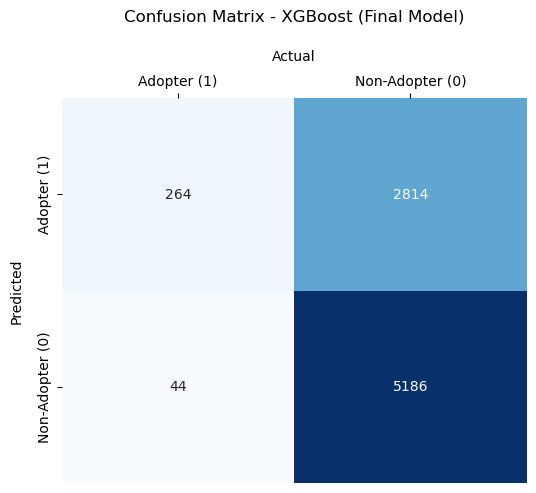

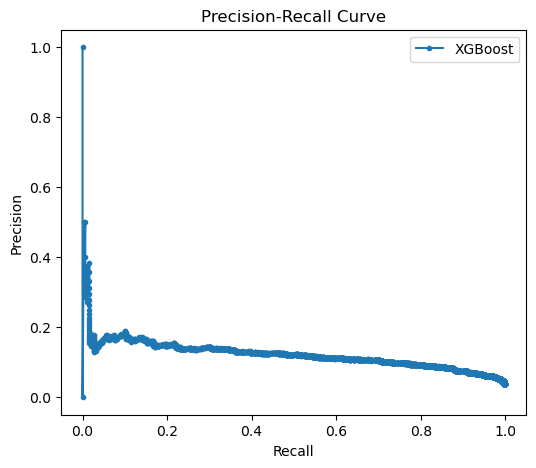

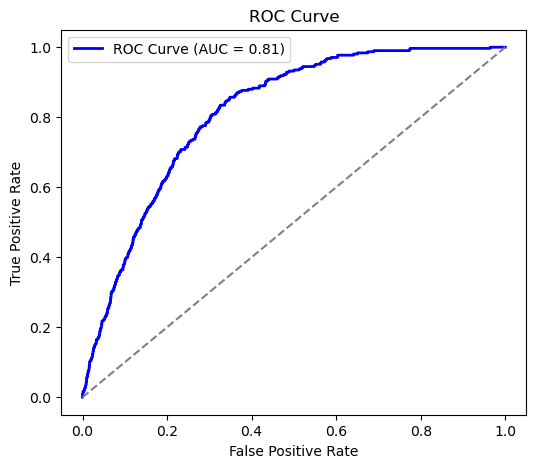

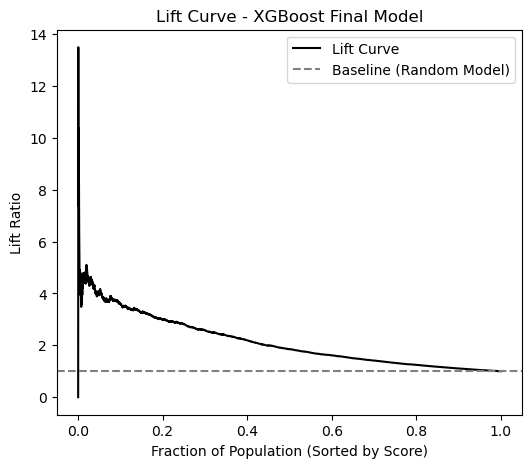

In [23]:
# === Confusion Matrix ===
conf_matrix = confusion_matrix(y_test_main, y_pred_final)
confusion_matrices = [conf_matrix]

selected_fold_cm = confusion_matrices[-1]
selected_fold_cm_plot = np.array([
    [selected_fold_cm[1, 1], selected_fold_cm[0, 1]],  # TP, FP
    [selected_fold_cm[1, 0], selected_fold_cm[0, 0]]   # FN, TN
])

plt.figure(figsize=(6, 5))
ax = sns.heatmap(selected_fold_cm_plot, annot=True, fmt='g', cmap='Blues', cbar=False, 
                 xticklabels=['Adopter (1)', 'Non-Adopter (0)'], 
                 yticklabels=['Adopter (1)', 'Non-Adopter (0)'])
ax.xaxis.set_ticks_position('top')  
ax.xaxis.set_label_position('top')
plt.title('Confusion Matrix - XGBoost (Final Model)', pad=20, loc='center')
plt.xlabel('Actual', labelpad=10)
plt.ylabel('Predicted', labelpad=10)
plt.show()

# === Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_test_main, y_proba_final)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test_main, y_proba_final)
roc_auc = roc_auc_score(y_test_main, y_proba_final)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# === Lift Curve ===
lift_df = pd.DataFrame({
    "prob": y_proba_final,
    "actual": (y_test_main == 1).astype(int)
})
lift_df = lift_df.sort_values(by="prob", ascending=False).reset_index(drop=True)
lift_df["x"] = (lift_df.index + 1) / len(lift_df)
lift_df["y"] = (lift_df["actual"].cumsum() / lift_df["actual"].sum()) / lift_df["x"]

plt.figure(figsize=(6, 5))
plt.plot(lift_df["x"], lift_df["y"], color='black', lw=1.5, label="Lift Curve")
plt.axhline(y=1, color='grey', linestyle="--", label="Baseline (Random Model)")
plt.xlabel("Fraction of Population (Sorted by Score)")
plt.ylabel("Lift Ratio")
plt.title("Lift Curve - XGBoost Final Model")
plt.legend()
plt.show()

Simulated campaign ROI based on model predictions:

- Let marketers **input campaign cost per user** and **expected revenue per adoption**.
- Users are sorted by predicted probabilities.
- ROI is computed for the **top K% targeted users**.

Metrics displayed:

- Targeted Users
- Predicted Adopters
- Estimated ROI

In [24]:
# === ROI Analysis at Top-K (Optional) ===

top_k = 0.2  # top 20% of customers
cost_per_customer = 1.00  # e.g. $1 per outreach
revenue_per_conversion = 25.00  # e.g. $10 per upgrade

k_cutoff = int(len(lift_df) * top_k)
targeted = lift_df.iloc[:k_cutoff]

n_targeted = len(targeted)
n_positives = targeted["actual"].sum()

total_cost = n_targeted * cost_per_customer
total_revenue = n_positives * revenue_per_conversion
roi = (total_revenue - total_cost) / total_cost

print("\n ROI at Top 20% Targeting:")
print(f"People Targeted: {n_targeted}")
print(f"True Adopters Captured: {n_positives}")
print(f"Total Cost: ${total_cost:.2f}")
print(f"Total Revenue: ${total_revenue:.2f}")
print(f"ROI: {roi:.2f}")


 ROI at Top 20% Targeting:
People Targeted: 1661
True Adopters Captured: 184
Total Cost: $1661.00
Total Revenue: $4600.00
ROI: 1.77


# 8. SHAP Global & Local

Used SHAP (SHapley Additive exPlanations) to:

- Understand the **impact** of each feature on model predictions.
- Identify **Top 5 business-friendly features** influencing adoption:
  - Avg Age of Friends
  - Songs Listened
  - Loved Tracks
  - User Age
  - Friends Who Subscribed

These were visualized using SHAP summary plots (beeswarm + bar).

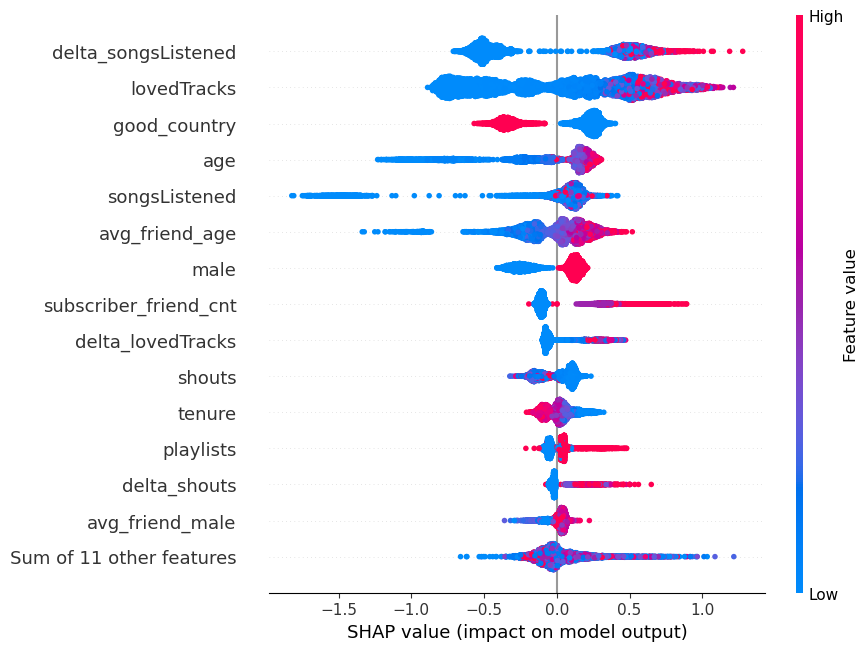

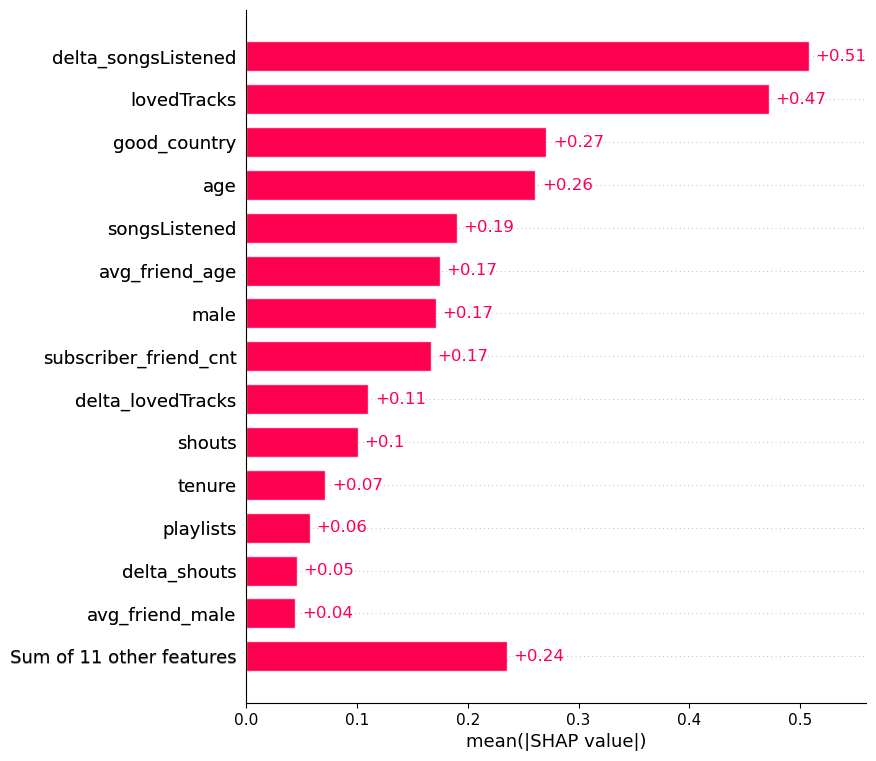

In [26]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_main),
    columns=X_train_main.columns,
    index=X_train_main.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_main),
    columns=X_test_main.columns,
    index=X_test_main.index
)

final_model = XGBClassifier(**xgb_final_params)
final_model.fit(X_train_scaled, y_train_main)

explainer = shap.Explainer(final_model, X_train_scaled)

shap_values = explainer(X_test_scaled)

shap.plots.beeswarm(shap_values, max_display=15)

shap.plots.bar(shap_values, max_display=15)

# 9. Save Model

In [28]:
joblib.dump({"model": final_model, "scaler": scaler}, "marketing_classifier_bundle.pkl")

bundle = joblib.load("marketing_classifier_bundle.pkl")
model = bundle["model"]
scaler = bundle["scaler"]

In [36]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [38]:
scaler

StandardScaler()

# 10. App Deployment

### Streamlit App Deployment

To make the adoption prediction workflow interactive and accessible to business users, the entire pipeline was deployed using **Streamlit**. The web app enables marketing analysts to upload new customer lead files and simulate ROI under different targeting thresholds.

#### App Features:
- **CSV Upload:** Upload new customer leads for prediction.
- **Model Scoring:** Automatically applies the best XGBoost model with calibrated thresholds for high recall.
- **Top Features:** SHAP-based feature impact is visualized with clear business interpretation.
- **LLM-Powered Insights:**
  - Business-language explanations for top predictive features.
  - Three campaign ideas tailored to user behavior patterns, auto-generated via Mistral-7B.
- **ROI Simulation:** Users can input marketing cost per customer and revenue per conversion to calculate estimated ROI.
- **Download Results:** Export the scored leads with prediction probabilities and suggested actions.

#### Sample Use Case:
> A marketing analyst can upload new lead data, select the top 10% of leads, and see the **expected number of premium adopters**, **estimated ROI**, and **campaign suggestions** generated by a lightweight LLM.

#### Deployment Method:
- Developed using **Streamlit** with a responsive and intuitive UI.
- Uses **Mistral-7B Instruct** (via Hugging Face Inference API) for campaign recommendations and feature insights.
- All model artifacts (`XGBoost model`, `Scaler`, and `SHAP explainer`) are bundled via `joblib` and reloaded dynamically during app startup.

---

